In [1]:
# Import necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tqdm
import random
import os

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [5]:
### READ DATA ###

df = pd.read_excel('Folds5x2_pp.xlsx', engine='openpyxl')
print(df.shape)
df.head()

(9568, 5)


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


<AxesSubplot:>

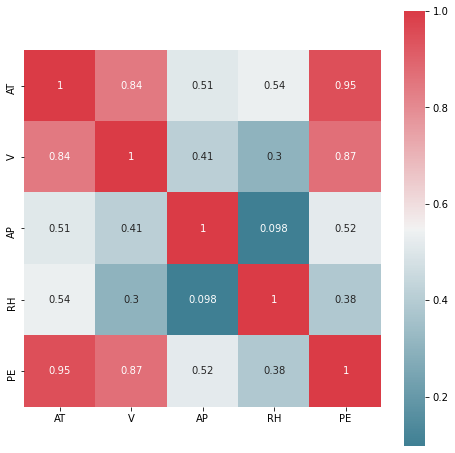

In [6]:
### PLOT CORRELATION MATRIX ###

plt.figure(figsize=(8,8))
train_size = int(df.shape[0]*0.8)
corr_matrix = df.iloc[:train_size,:].corr().abs()
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, annot=True)

In [7]:
### TRAIN TEST SPLIT ###

X, y = ['AT','V','AP','RH'], ['PE']
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size = 0.2, random_state = 42)

# GRADIENT BOOSTING FEATURE IMPORTANCES

In [8]:
### FIT GRADIENTBOOSTING ###

gb = GradientBoostingRegressor(n_estimators=100)
gb.fit(X_train, y_train.values.ravel())

GradientBoostingRegressor()

In [9]:
### PREDICTION ERROR ON TEST DATA ###

mean_absolute_error(y_test, gb.predict(X_test))

2.9481019274797413

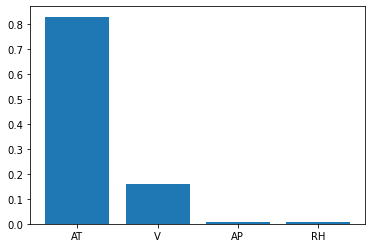

In [10]:
### FEATURE IMPORTANCES REPORT ###

plt.bar(range(X_train.shape[1]), gb.feature_importances_)
plt.xticks(range(X_train.shape[1]), ['AT','V','AP','RH'])
np.set_printoptions(False)

# PERMUTATION IMPORTANCE

In [11]:
### SCALE DATA FOR NN ###

scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

In [12]:
### UTILITY FUNCTIONS TO SCALE TARGET ###

mean_train = y_train.mean().values
std_train = y_train.std().values

def scale_target(y, mean, std):
    return np.asarray((y - mean)/std)

def reverse_target(pred, mean, std): 
    return np.asarray(pred*std + mean)

In [13]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


### DEFINE NN STRUCTURE ###

inp = Input(shape=(scaled_train.shape[1],))
x = Dense(128, activation='relu')(inp)
x = Dense(32, activation='relu')(x)
out = Dense(1)(x)
model = Model(inp, out)

model.compile(optimizer='adam', loss='mse')
model.fit(scaled_train, scale_target(y_train, mean_train, std_train) , epochs=100, batch_size=128 ,verbose=2)

Epoch 1/100
60/60 - 0s - loss: 0.2498
Epoch 2/100
60/60 - 0s - loss: 0.0659
Epoch 3/100
60/60 - 0s - loss: 0.0619
Epoch 4/100
60/60 - 0s - loss: 0.0607
Epoch 5/100
60/60 - 0s - loss: 0.0604
Epoch 6/100
60/60 - 0s - loss: 0.0596
Epoch 7/100
60/60 - 0s - loss: 0.0592
Epoch 8/100
60/60 - 0s - loss: 0.0589
Epoch 9/100
60/60 - 0s - loss: 0.0587
Epoch 10/100
60/60 - 0s - loss: 0.0584
Epoch 11/100
60/60 - 0s - loss: 0.0582
Epoch 12/100
60/60 - 0s - loss: 0.0584
Epoch 13/100
60/60 - 0s - loss: 0.0579
Epoch 14/100
60/60 - 0s - loss: 0.0574
Epoch 15/100
60/60 - 0s - loss: 0.0575
Epoch 16/100
60/60 - 0s - loss: 0.0579
Epoch 17/100
60/60 - 0s - loss: 0.0573
Epoch 18/100
60/60 - 0s - loss: 0.0570
Epoch 19/100
60/60 - 0s - loss: 0.0573
Epoch 20/100
60/60 - 0s - loss: 0.0567
Epoch 21/100
60/60 - 0s - loss: 0.0569
Epoch 22/100
60/60 - 0s - loss: 0.0567
Epoch 23/100
60/60 - 0s - loss: 0.0571
Epoch 24/100
60/60 - 0s - loss: 0.0568
Epoch 25/100
60/60 - 0s - loss: 0.0563
Epoch 26/100
60/60 - 0s - loss: 0.

In [14]:
### PREDICTION ERROR ON TEST DATA ###

real_pred = reverse_target(model.predict(scaled_test).ravel(), mean_train, std_train) 
MAE = mean_absolute_error(y_test, real_pred)

MAE

3.0032559295817047

In [15]:
### COMPUTE PERMUTATION AND SCORING ###

os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

final_score = []
shuff_pred = []

for i,col in enumerate(X_test.columns):

    # shuffle column
    shuff_test = scaled_test.copy()
    shuff_test[:,i] = np.random.permutation(shuff_test[:,i])
    
    # compute score
    score = mean_absolute_error(y_test, reverse_target(model.predict(shuff_test).ravel(), mean_train, std_train))
    shuff_pred.append(reverse_target(model.predict(shuff_test).ravel(), mean_train, std_train))
    final_score.append(score)
    
final_score = np.asarray(final_score)
final_score

array([17.,  6.,  4.,  4.])

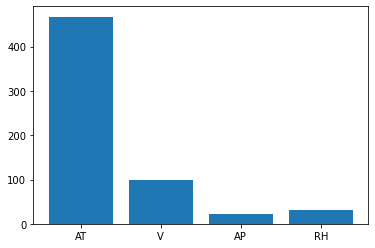

In [16]:
### PERMUTATION IMPORTANCE REPORT ###

plt.bar(range(X_train.shape[1]), (final_score - MAE)/MAE*100)
plt.xticks(range(X_train.shape[1]), ['AT','V','AP','RH'])
np.set_printoptions(False)

# EXPLAIN CASUALITY

In [17]:
### SIMULATE MEAN DIFFERENCE TEST AMONG PREDICTIONS ###

os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

id_ = 0

merge_pred = np.hstack([shuff_pred[id_], real_pred])
observed_diff = abs(shuff_pred[id_].mean() - merge_pred.mean())
extreme_values = []
sample_d = []

for _ in range(10000):
    sample_mean = np.random.choice(merge_pred, size=shuff_pred[id_].shape[0]).mean()
    sample_diff = abs(sample_mean - merge_pred.mean())
    sample_d.append(sample_diff)
    extreme_values.append(sample_diff >= observed_diff)
    
np.sum(extreme_values)/10000

0.0509

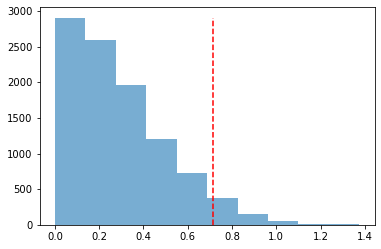

In [18]:
### PLOT MEAN DIFFERENCE DISTRIBUTIONS ###

y, x, _ = plt.hist(sample_d, alpha=0.6)
plt.vlines(observed_diff, 0,max(y), colors='red', linestyles='dashed')